## Part 4: Final Model and Evaluation

In [2]:
import requests
import re
import pickle
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance

### Import and preprocessing steps

In [6]:
df = pd.read_pickle('./data/cleaned.pkl')
df['subreddit'] = df['subreddit'].map({'marvelstudios':0, 'DC_Cinematic':1})
X = df[['title_combined']]
y = df['subreddit']

In [7]:
def lemmatise(text):
    # the default NLTK stopword list
    stop_words = set(stopwords.words('english'))  

    # add additional stopwords
    additional_stopwords = {'like','think','just','new'}
    stop_words = stop_words.union(additional_stopwords)
   # Split and lemmatize words
    words = text.split(" ")
    lemmatizer = WordNetLemmatizer()
    words_lem = [lemmatizer.lemmatize(i) for i in words]

    # Join the words back into one string separated by space, 
    # and return the result.
    words=[]
    for i in (words_lem):   
        if i != "":
            words.append(i)
    
    no_stop_words = [token for token in words if token not in stop_words]

    return (' '.join(no_stop_words))

In [8]:
X['title_combined']= X['title_combined'].apply(lambda x: lemmatise(x))

C:\Users\pkfei\AppData\Local\Temp/ipykernel_74272/824450830.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['title_combined']= X['title_combined'].apply(lambda x: lemmatise(x))


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

In [10]:
cvec = CountVectorizer(max_df=0.85,max_features=1500)
Z_train = cvec.fit_transform(X_train['title_combined'])
Z_test = cvec.transform(X_test['title_combined'])
X_train_df = pd.DataFrame(Z_train.todense(),                  
                          columns=cvec.get_feature_names())
X_test_df = pd.DataFrame(Z_test.todense(),                  
                          columns=cvec.get_feature_names())

C:\Users\pkfei\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Models Evaluation

3 models selected from hyperparameter tuning - Multinomial NB, Random Forest and Gradient Boosting

The Evaluation metrics including:
1. Scores (test data scores, F1 scores, accuracy , sensitivity, precision and etc)
2. Confusion matrix
3. ROC curve - (AUC)
4. Feature importance (will only evaluate on the best performance model - Gradient BOOSTING)

In [11]:
#Instantiate the models and fit

# Model 1 - Random forest
rf = RandomForestClassifier(max_depth=6, max_features=12,min_samples_leaf=2, min_samples_split=10,n_estimators=190,random_state=42)
rf.fit(Z_train,y_train)

#Model 2 - Multinomial Naive Bayes
nb = MultinomialNB(alpha=0.6)
nb.fit(Z_train,y_train)

#Model 3 - Gradient Boosting
gb = GradientBoostingClassifier(learning_rate=0.12, max_depth=4,
                                            max_features=12, min_samples_leaf=2,
                                            min_samples_split=10,
                                            n_estimators=150,
                                            random_state=42)
gb.fit(Z_train,y_train)

GradientBoostingClassifier(learning_rate=0.12, max_depth=4, max_features=12,
                           min_samples_leaf=2, min_samples_split=10,
                           n_estimators=150, random_state=42)

In [15]:
#Evaluations function 

eval = {}

def evaluate(model,name): 
    
    pred = model.predict(Z_test)
    probs = model.predict_proba(Z_test)
    probs = probs[:, 1]
    # auc score
    auc = roc_auc_score(y_test, probs)
    fpr, tpr, _ = roc_curve(y_test, probs)

    tn, fp, fn, tp = confusion_matrix(y_test,
                                  pred).ravel()

    print(f'Train Accuracy: {model.score(Z_train,y_train)}') 
    print(f'Test Accuracy: {model.score(Z_test,y_test)}')
    print(f'Generalisation: {round(abs(100*(model.score(Z_test,y_test)-model.score(Z_train,y_train))/model.score(Z_test,y_test)),2)}%')
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    print(f'Misclassification: {1 - accuracy}')
    print(f'Sensitivity: {tp / (tp + fn)}')
    print(f'Specificity: {tn / (tn + fp)}')
    print(f'Precision: {tp / (tp + fp)}')

    fig,ax = plt.subplots(figsize=(5,5))

    plot_confusion_matrix(model, Z_test, y_test, cmap = 'Blues', values_format ='d',display_labels=['MarvelStudio','DC Cinematic'],ax=ax)

    plt.title('Confusion Matrix',fontsize=20)
    ax.set_xlabel('Predicted label',fontsize=15)
    ax.set_ylabel('True Label',fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=12)

    print(classification_report(y_test,pred))
    auc = round(auc,2)
    
    #store data for ROC curve plotting
    eval[name] = [fpr,tpr,auc]



Train Accuracy: 0.8784326858673811
Test Accuracy: 0.8403614457831325
Generalisation: 4.53%
Misclassification: 0.15963855421686746
Sensitivity: 0.7650602409638554
Specificity: 0.9156626506024096
Precision: 0.900709219858156
              precision    recall  f1-score   support

           0       0.80      0.92      0.85       498
           1       0.90      0.77      0.83       498

    accuracy                           0.84       996
   macro avg       0.85      0.84      0.84       996
weighted avg       0.85      0.84      0.84       996



C:\Users\pkfei\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


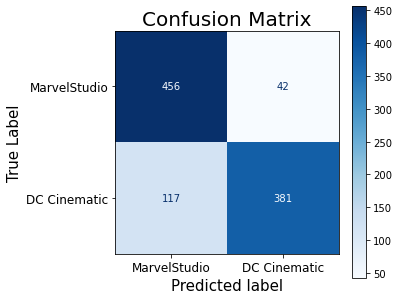

In [16]:
evaluate(rf,'random_forest')

Train Accuracy: 0.9249832551908909
Test Accuracy: 0.8614457831325302
Generalisation: 7.38%
Misclassification: 0.13855421686746983
Sensitivity: 0.8333333333333334
Specificity: 0.8895582329317269
Precision: 0.8829787234042553
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       498
           1       0.88      0.83      0.86       498

    accuracy                           0.86       996
   macro avg       0.86      0.86      0.86       996
weighted avg       0.86      0.86      0.86       996



C:\Users\pkfei\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


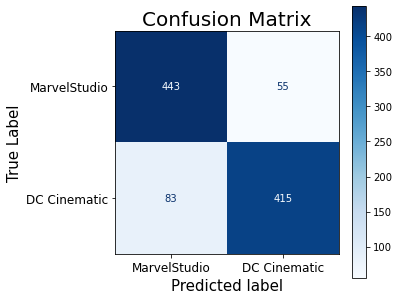

In [17]:
evaluate(nb,'Multinomial NB')

Train Accuracy: 0.9042196918955124
Test Accuracy: 0.8664658634538153
Generalisation: 4.36%
Misclassification: 0.13353413654618473
Sensitivity: 0.9377510040160643
Specificity: 0.7951807228915663
Precision: 0.820738137082601
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       498
           1       0.82      0.94      0.88       498

    accuracy                           0.87       996
   macro avg       0.87      0.87      0.87       996
weighted avg       0.87      0.87      0.87       996



C:\Users\pkfei\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


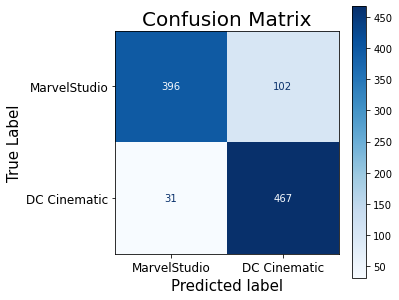

In [18]:
evaluate(gb,'gradient_boosting')

In [19]:
# Setting up to plot ROC curves

df_eva = pd.DataFrame(eval, index=['fpr','tpr','auc']).T
df_eva['model']=df_eva.index
df_eva=df_eva.reset_index(drop=True)


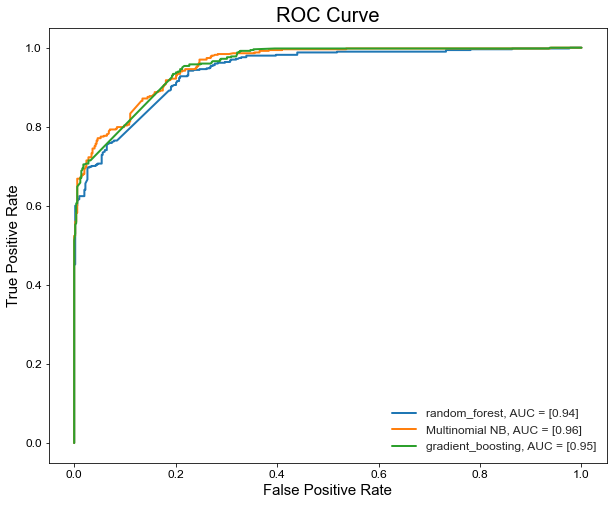

In [20]:
fig,ax = plt.subplots(figsize=(10,8))
plt.style.use('seaborn')
for model in df_eva['model']:
  auc = df_eva[df_eva['model']==model]['auc'].values
  plt.plot(df_eva[df_eva['model']==model]['fpr'].values[0],df_eva[df_eva['model']==model]['tpr'].values[0], label = f'{model}, AUC = {auc}',linewidth=2)

plt.title('ROC Curve',fontsize=20)
ax.set_xlabel('False Positive Rate',fontsize=15)
ax.set_ylabel('True Positive Rate',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12,loc='lower right')

In [21]:
#Discover best model feature importance

start_time = time.time()
perm_imp = permutation_importance(gb, X_test_df , y_test, n_repeats=8, random_state=42, n_jobs=-1,scoring='accuracy')
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

C:\Users\pkfei\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Elapsed time to compute the importances: 95.863 seconds


C:\Users\pkfei\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


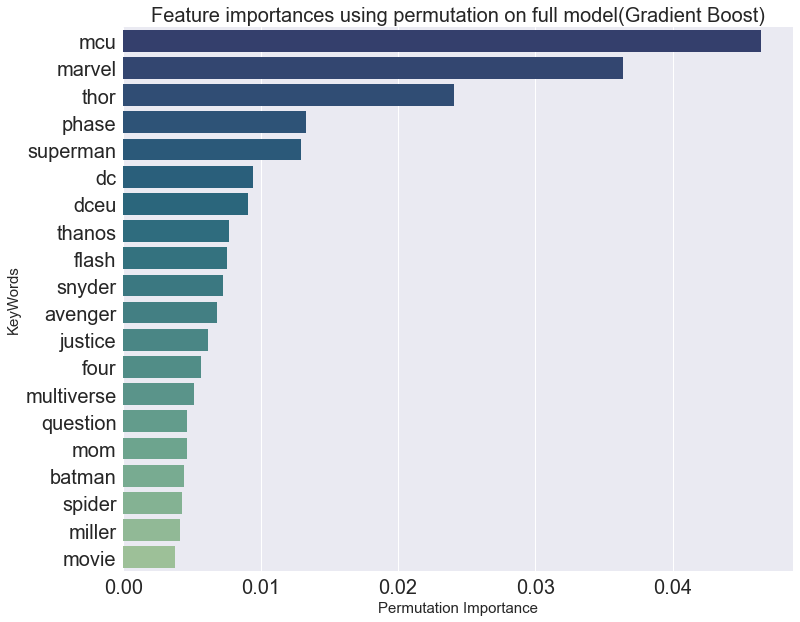

In [23]:
# Get the top 20 features with high predictive power
gb_importances = pd.DataFrame(data = {'words':cvec.get_feature_names(),'fea_imp':perm_imp.importances_mean}).sort_values(by=['fea_imp'],ascending=False)[0:20]

fig,ax = plt.subplots(figsize=(12,10))
sns.barplot(gb_importances.fea_imp, gb_importances.words,orient='h',palette='crest_r')
plt.title("Feature importances using permutation on full model(Gradient Boost)",fontsize=20)
ax.set_xlabel("Permutation Importance",fontsize=15)
ax.set_ylabel("KeyWords",fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()

### Further study on effect of ngram and number of features in count vectorizer on our best model

In [24]:
ngram = [ (1,1),(1,2),(2,2),(2,3)]
fea = [1000,1500,2000,2500,3000,3500,4000,4500,5000]

In [25]:
ngram_score=[]
for i in range(len(ngram)):
  cvec = CountVectorizer(max_df=0.85,max_features=1500,ngram_range=ngram[i])
  Z_train = cvec.fit_transform(X_train['title_combined'])
  Z_test = cvec.transform(X_test['title_combined'])
  gb = GradientBoostingClassifier(learning_rate=0.12, max_depth=4,
                                            max_features=12, min_samples_leaf=2,
                                            min_samples_split=10,
                                            n_estimators=150,
                                            random_state=42)
  gb.fit(Z_train,y_train)
  score = gb.score(Z_test,y_test)
  ngram_score.append(score)

  

In [26]:
fea_score=[]
for i in range(len(fea)):
  cvec = CountVectorizer(max_df=0.85,max_features=fea[i])
  Z_train = cvec.fit_transform(X_train['title_combined'])
  Z_test = cvec.transform(X_test['title_combined'])
  gb = GradientBoostingClassifier(learning_rate=0.12, max_depth=4,
                                            max_features=12, min_samples_leaf=2,
                                            min_samples_split=10,
                                            n_estimators=150,
                                            random_state=42)
  gb.fit(Z_train,y_train)
  score = gb.score(Z_test,y_test)
  fea_score.append(score)
  

In [27]:
df_ngram = pd.DataFrame(data={'ngram':ngram,'score':ngram_score})
df_fea = pd.DataFrame(data={'fea':fea,'score':fea_score})

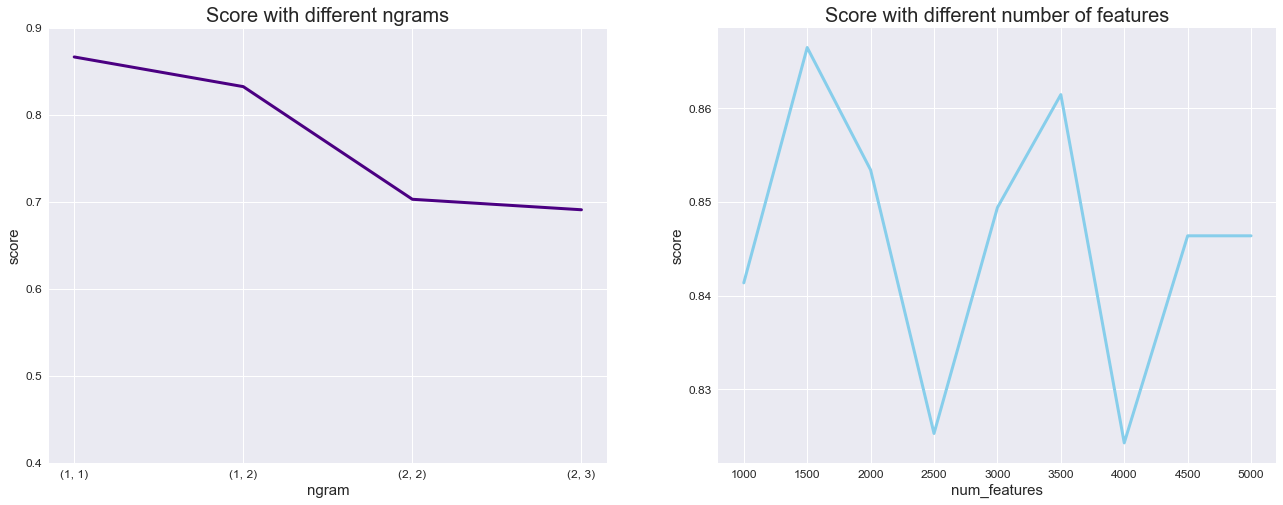

In [28]:
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(22,8), sharex = False)
sns.lineplot(data=df_ngram, y='score',  x =df_ngram['ngram'].astype(str),ax=ax[0], markers=True, dashes=False,linewidth=3,color='indigo')
ax[0].set_title('Score with different ngrams',fontsize=20)
ax[0].set_xlabel('ngram', fontsize=15)
ax[0].set_ylabel("score",fontsize=15)
ax[0].set_ylim(0.4,0.9)
ax[0].tick_params(axis='both', which='major', labelsize=12)

sns.lineplot(data=df_fea, y='score', x = 'fea',ax=ax[1], markers=True, dashes=False,linewidth=3,color='skyblue')
ax[1].set_xlabel('num_features', fontsize=15)
ax[1].set_title('Score with different number of features',fontsize=20)
ax[1].set_ylabel("score",fontsize=15)


ax[1].tick_params(axis='both', which='major', labelsize=12)


The plot tells that for this classification project, ngrams with (1,1) is the best fit and number of features in CountVectorizer does not contribute to the performance of model.

### Conclusion

3 models final performance:

|Model|Train Score|Test Score|Generalization Gap|AUC|F1 score(for class 1)|
|---|---|---|---|---|---|
|Gradient Boosting|0.90|0.87|4.36%|0.95|0.88|
|Multinomial NB|0.92|0.86|7.4%|0.96|0.86|
|Random Forest|0.88|0.84|4.53%|0.94|0.83|



In this project, the Gradient Boosting model is the best to predict the subreddit page (MarvelStudio and DC Cinematic) with ROC-AUC of 0.95. The class 0 (Marvel Studio) F1 score is 0.88 and class 1 (DC Cinematic) F1 score is 0.86 with good generalisation!

The NLP & classification modelling can be improved through hyperparameter tuning (RandomizedSearchCV and GridSearchCV), we must weight the trade off between the target performance and computation time. The ROC curve plot is very easy to visualize the performance of each model in doing correct prediction. 